Set up environment

In [1]:
from collections import OrderedDict
import copy
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
sns.set_style("white")
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from sklearn.preprocessing import scale

Import custom modules

In [2]:
import sys
sys.path.append('../')
sys.path.append('../../utils/')

# Helper functions for eGLM 
from eGLM_helpers import phi, run_ucr_glm, run_ext_glm, make_stimtimes, sim_network_task_glm, get_res_ts, get_res_taskreg, get_true_baseline, plot_sim_network_glm
import model

Importing eGLM helpers...
All eGLM helpers imported!


Goal of this notebook: Create the most minimal RNN that will be used in the more extended simulations to understand how activity propogates depending on the various parameters.

The network model describes change in activity as follows:

\begin{equation*}
\frac{dx_i}{dt}\tau_i = -x_i(t) + s\phi\big(x_i(t)\big) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(x_j(t)\big)\Bigg) + I_i(t)
\end{equation*}

We create network with 9 nodes with the following connectivity matrix. The first community (nodes 0-2) is a hub community and the other two are local communities.

In [3]:
ncommunities = 3
innetwork_dsity = .6
outnetwork_dsity = .08
hubnetwork_dsity = .5
nodespercommunity = 3
plot_network = False

totalnodes = nodespercommunity*ncommunities

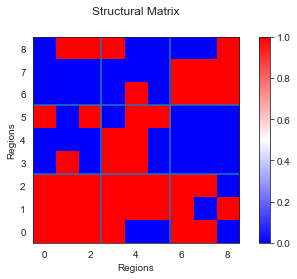

In [4]:
# Construct structural matrix
S = model.generateStructuralNetwork(ncommunities=ncommunities,
                                    innetwork_dsity=innetwork_dsity,
                                    outnetwork_dsity=outnetwork_dsity,
                                    hubnetwork_dsity=hubnetwork_dsity,
                                    nodespercommunity=nodespercommunity,
                                    showplot=True)

plt.hlines(y=2.5, xmin = -0.5, xmax = 8.5)
plt.hlines(y=5.5, xmin = -0.5, xmax = 8.5)
plt.vlines(x=2.5, ymin = -0.5, ymax = 8.5)
plt.vlines(x=5.5, ymin = -0.5, ymax = 8.5)

Note in this matrix:

`W[..., x]` : column x of matrix denotes all outgoing connection weights from node x  
`W[x, ...]` : row x of matrix denotes all incoming connection weights to node x

In [5]:
# Construct synaptic matrix
W = model.generateSynapticNetwork(S, showplot=False)

In [6]:
Tmax = 1000
dt = 1
T = np.arange(0,Tmax,dt)

# Construct a community affiliation vector
Ci = np.repeat(np.arange(ncommunities),nodespercommunity) 
# Identify the regions associated with the hub network (hub network is by default the 0th network)
hub_ind = np.where(Ci==0)[0] 

stimsize = nodespercommunity

# This works because if there is a hub network the first nodes are the hub nodes
stim_nodes_td = np.arange(0, stimsize, dtype=int)
#stim_nodes_td

This network is stimulated topdown (i.e. only the hub nodes) with the following task:

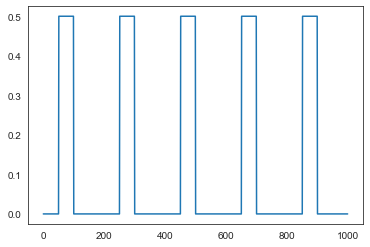

In [7]:
sa = 50
ea = 100
iv = 200
tasktiming, stimtimes = make_stimtimes(Tmax=1000, dt=1, stim_nodes= stim_nodes_td, stim_mag=0.5, sa = sa, ea = ea, iv = iv,
                          ncommunities = ncommunities, nodespercommunity = nodespercommunity)
plt.plot(stimtimes[0])

In [8]:
taskdata, noise = model.networkModel(W, Tmax=Tmax,dt=dt,
                                     g=1, s=1, tau=1, I=stimtimes, 
                                     noise=None)

In [9]:
#Visualize what is going on on the network
#Three scatter plots with three curves for the timeseries/activity of each node in that community
taskdata_df = pd.DataFrame(taskdata)
taskdata_df['node_num'] = taskdata_df.index
taskdata_df['com_num'] = [0,0,0,1,1,1,2,2,2]
taskdata_df = taskdata_df.melt(id_vars = ['node_num', 'com_num'])
taskdata_df = taskdata_df.rename(columns={"variable": "time", "value": "activity"})

Timeseries/activity for each node in each community.  

Since only the hub network is stimulated by the task the amount of activity will depend on number (/strength) of incoming connections from hub network nodes. If a node does not have any incoming connections from the hub network its activity will not change from 0.

Connections from the hub community to the other communities can be checked on the columns going out of the hub nodes (in this case the first three columns).

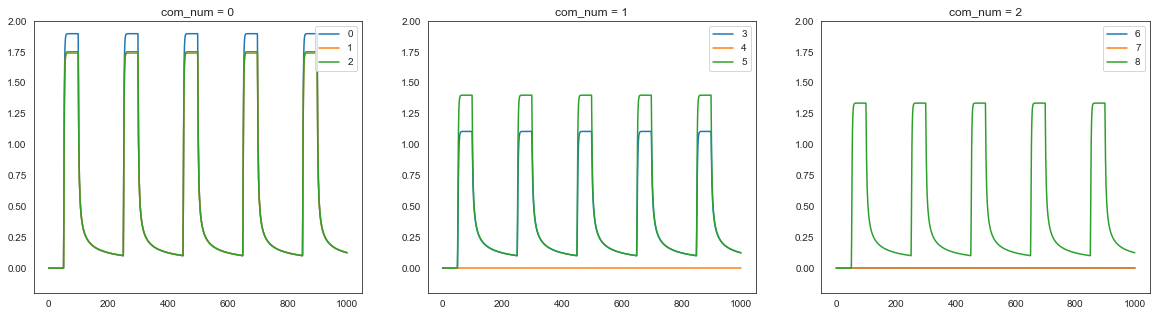

In [10]:
plt.rcParams["figure.figsize"][0] = 20
plt.rcParams["figure.figsize"][1] = 5
fig, a = plt.subplots(1, 3)

for cur_com in taskdata_df.com_num.unique():
    
    cur_vals = ["C"+str(x) for x in range(len(taskdata_df.query("com_num==@cur_com").node_num.unique()))]
    cur_col_lookup = dict(zip(taskdata_df.query("com_num==@cur_com").node_num.unique(), cur_vals))
    
    for cur_node in taskdata_df.query("com_num==@cur_com").node_num.unique():
        tmp = taskdata_df.query("com_num==@cur_com & node_num==@cur_node")
        a[cur_com].plot(tmp['time'], tmp['activity'], color = cur_col_lookup[cur_node], label = cur_node)
        a[cur_com].set_ylim([-0.2,2])
        a[cur_com].set_title("com_num = %s"%(str(cur_com)))
        a[cur_com].legend(loc="upper right")

Note that activity builds up and decreases in several time steps:

(-0.2, 2.0)

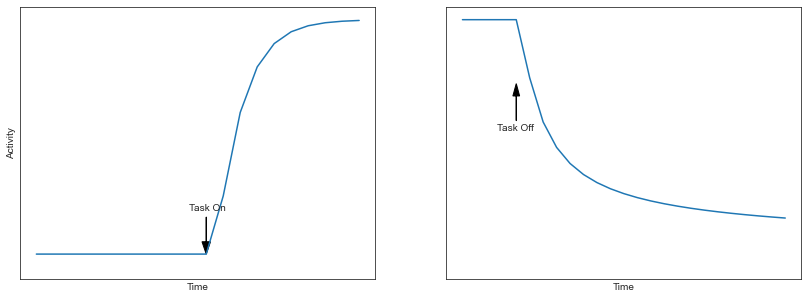

In [11]:
plt.rcParams["figure.figsize"][0] = 14
plt.rcParams["figure.figsize"][1] = 5
fig, a = plt.subplots(1, 2)


a[0].plot(taskdata[0, 40:60])
a[0].annotate("Task On", xy=(9, 0.35), xytext=(9, 0.35))
a[0].arrow(10, 0.3, 0, -0.2, head_width=0.5, head_length=0.1, fc='k', ec='k')
a[0].set_xticks([])
a[0].set_yticks([])
a[0].set_xlabel("Time")
a[0].set_ylabel("Activity")
a[0].set_ylim([-0.2,2])

a[1].plot(taskdata[0, 95:120])
a[1].annotate("Task Off", xy=(2.6, 1), xytext=(2.6, 1))
a[1].arrow(4, 1.08, 0, 0.2, head_width=0.5, head_length=0.1, fc='k', ec='k')
a[1].set_xticks([])
a[1].set_yticks([])
a[1].set_xlabel("Time")
a[1].set_ylabel("")
a[1].set_ylim([-0.2,2])


Back to the data generating process:

\begin{equation*}
\frac{dx_i}{dt}\tau_i = -x_i(t) + s\phi\big(x_i(t)\big) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(x_j(t)\big)\Bigg) + I_i(t)
\end{equation*}

\begin{equation*}
x_i(t+1) = \frac{dx_i}{dt}\tau_i + x_i(t)
\end{equation*}

So the GLM to invert should be:

\begin{equation*}
x_i(t+1) = s\phi\big(x_i(t)\big) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(x_j(t)\big)\Bigg) + I_i(t)
\end{equation*}

Plot the classic and extended GLMs for a stimulated vs non-stimulated node

In [51]:
s = 1
g = 1
node = 0

#Drop the first time point
y = taskdata[node,1:]

#intercept
intcp = np.ones_like(y)

#Drop last time point
s_phi_x = s*phi(taskdata[node,:-1])

g_w_phi_x = np.delete(taskdata, node, axis=0)[:,:-1]
g_w_phi_x = np.apply_along_axis(phi, 0, g_w_phi_x)
cur_w = np.delete(W[node,:], node, axis=0)
cur_w = cur_w.reshape(-1,1)
g_w_phi_x = cur_w * g_w_phi_x
g_w_phi_x = np.sum(g_w_phi_x, axis=0)
g_w_phi_x = g*g_w_phi_x

i_t = stimtimes[node,:-1]

old_des_mat = np.column_stack((intcp, i_t))
new_des_mat = np.column_stack((intcp, s_phi_x, g_w_phi_x, i_t))

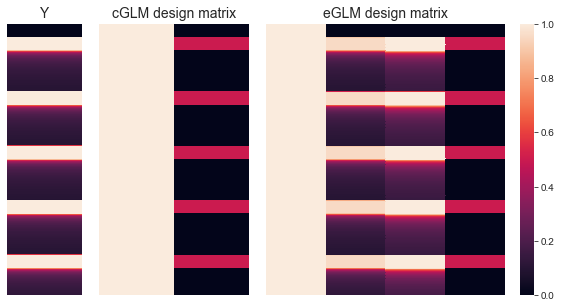

In [52]:
plt.rcParams["figure.figsize"][0] = 10
plt.rcParams["figure.figsize"][1] = 5
fig, a = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 2, 4]})

a[0].set_title("Y", fontdict = {'fontsize':14})
a[1].set_title("cGLM design matrix", fontdict = {'fontsize':14})
a[2].set_title("eGLM design matrix", fontdict = {'fontsize':14})

sns.heatmap(y.reshape(-1,1), xticklabels=False, yticklabels=False, cbar=False, ax = a[0], vmin = 0 , vmax = 1)
sns.heatmap(old_des_mat, xticklabels=False, yticklabels=False, cbar=False, ax = a[1], vmin = 0 , vmax = 1)
sns.heatmap(new_des_mat, xticklabels=False, yticklabels=False, cbar=True, ax = a[2], vmin = 0 , vmax = 1)

plt.subplots_adjust(wspace=0.1)

In [53]:
mod_df = pd.DataFrame(data = {"y": y, "s_phi_x":s_phi_x, "g_w_phi_x":g_w_phi_x, "i_t":i_t})
old_mod = smf.ols(formula = 'y ~ i_t', data = mod_df).fit()
mid_mod = smf.ols(formula = 'y ~ s_phi_x + g_w_phi_x', data = mod_df).fit()
new_mod = smf.ols(formula = 'y ~ s_phi_x + g_w_phi_x + i_t', data = mod_df).fit()

In [54]:
print("cGLM task parameter estimate: %s"%(str(round(old_mod.params['i_t'],3))))
print("eGLM task parameter estimate: %s"%(str(round(new_mod.params['i_t'],3))))

cGLM task parameter estimate: 3.343
eGLM task parameter estimate: 1.785


Model comparison to check if the addition of the regressors makes a significant improvement

In [55]:
anova_lm(old_mod, new_mod)

/Users/zeynepenkavi/anaconda/envs/py37/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/zeynepenkavi/anaconda/envs/py37/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/zeynepenkavi/anaconda/envs/py37/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,997.0,20.904067,0.0,NaN,NaN,NaN
1,995.0,2.484271,2.0,18.419796,3688.747622,0.0


What is the correct baseline?

Change in average activity when task is on compared to when task is off? No. This is "contaminated" by network activity.

Baseline should capture how much of the change in $y$ is due to $I(t)$ separate from the effect of the other two regressors. In other words it is the regression weight of $I(t)$ in the extended model for **noiseless data**
This way, baseline does **NOT** depend on noise but it **DOES** depend on the node's connectivity (so it wouldn't be the same for all nodes, even all stimulated nodes).

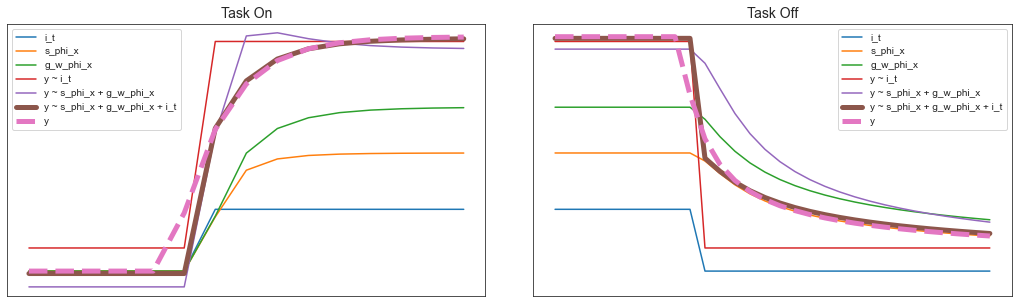

In [159]:
plt.rcParams["figure.figsize"][0] = 18
plt.rcParams["figure.figsize"][1] = 5
fig, a = plt.subplots(1, 2)

plt_ranges = [range(45,60), range(90,120)]
titles = ['Task On', "Task Off"]

for i, plt_range in enumerate(plt_ranges):
    a[i].plot(i_t[plt_range], label = "i_t")
    a[i].plot(s_phi_x[plt_range], label = "s_phi_x")
    a[i].plot(g_w_phi_x[plt_range], label = "g_w_phi_x")
    a[i].plot(old_mod.predict()[plt_range], label="y ~ i_t")
    a[i].plot(mid_mod.predict()[plt_range], label='y ~ s_phi_x + g_w_phi_x')
    a[i].plot(new_mod.predict()[plt_range], label='y ~ s_phi_x + g_w_phi_x + i_t', linewidth=5)
    a[i].plot(y[plt_range], label = "y", linewidth=5, linestyle='--')
    a[i].legend()
    a[i].set_title(titles[i], fontdict = {'fontsize':14})
    a[i].set_xticks([])
    a[i].set_yticks([])
    a[i].set_ylim([-.2,2])
    
plt.subplots_adjust(wspace=0.1)

In [ ]:
base_sim= sim_network_task_glm(ncommunities = ncommunities, 
                         nodespercommunity = nodespercommunity, 
                         dt = 1, tau = 1, g = 1, s = 1, 
                         Tmax = Tmax, 
                         stimsize = nodespercommunity, 
                         stim_mag = .5,
                         W = W,
                         taskdata = taskdata,
                         tasktiming = tasktiming,
                         sa = 50,
                         ea = 100,
                         iv = 200,
                         standardize=True)

base_sim_ns= sim_network_task_glm(ncommunities = ncommunities, 
                         nodespercommunity = nodespercommunity, 
                         dt = 1, tau = 1, g = 1, s = 1, 
                         Tmax = Tmax, 
                         stimsize = nodespercommunity, 
                         stim_mag = .5,
                         W = W,
                         taskdata = taskdata,
                         tasktiming = tasktiming,
                         sa = 50,
                         ea = 100,
                         iv = 200,
                         standardize=False)

How to analyze the relationship between the induced task activity and the timeseries of a node?  

What we want to capture is the change in activity in a node only due task and **not** due to amplification from the rest of the network. Since we know the task only stimulates the hub nodes in this stimulation we should find that only the relationship between the timeseries of those nodes and task should be >0 and everything else should be 0.

To get at this we examine the 'residualized' activity from each node. This is the remaining activity after regressing out the effect of everything else (see equations in the Extended_GLM_neural_network_level.ipynb) except the task.

In [ ]:
plt.rcParams["figure.figsize"][0] = 20
plt.rcParams["figure.figsize"][1] = 5
fig, a = plt.subplots(1, 3)

for cur_com in taskdata_df.com_num.unique():
    
    cur_vals = ["C"+str(x) for x in range(len(taskdata_df.query("com_num==@cur_com").node_num.unique()))]
    cur_col_lookup = dict(zip(taskdata_df.query("com_num==@cur_com").node_num.unique(), cur_vals))
    
    
    for cur_node in taskdata_df.query("com_num==@cur_com").node_num.unique():
        res_y, res_task = get_res_taskreg(base_sim, cur_node)
        a[cur_com].plot(res_y, color = cur_col_lookup[cur_node], label = cur_node)
        #a[cur_com].plot(res_task, "--",color = cur_col_lookup[cur_node], alpha=.5)
        a[cur_com].set_ylim([-.5,.5])
        a[cur_com].set_title("com_num = %s"%(str(cur_com)))
        a[cur_com].legend(loc="upper right")

In [ ]:
plt.rcParams["figure.figsize"][0] = 20
plt.rcParams["figure.figsize"][1] = 5
fig, a = plt.subplots(1, 3)

for cur_com in taskdata_df.com_num.unique():
    
    cur_vals = ["C"+str(x) for x in range(len(taskdata_df.query("com_num==@cur_com").node_num.unique()))]
    cur_col_lookup = dict(zip(taskdata_df.query("com_num==@cur_com").node_num.unique(), cur_vals))
    
    a[cur_com].plot([0, 1], [0, 1], "--",transform=a[cur_com].transAxes, color="black")
    a[cur_com].set_xlabel("Resid Activity")
    a[cur_com].set_ylabel("Resid Task")
    
    for cur_node in taskdata_df.query("com_num==@cur_com").node_num.unique():
        res_y, res_task = get_res_taskreg(base_sim, cur_node)
        a[cur_com].scatter(res_task, res_y, color = cur_col_lookup[cur_node], label = cur_node)
        a[cur_com].set_ylim([-.5,.5])
        a[cur_com].set_title("com_num = %s"%(str(cur_com)))
        a[cur_com].legend(loc="lower right")


Why does the difference between non stimulated and stimulated nodes disappear when you standardize? Because all time series are forced to look almost the same (same mean and same std) so the relationship between the now much more similar time series and the task regressor is very similar as well.  

To demonstrate this see below what happens to the timeseries of a stimulated and non-stimulated node with or without standardization.

In [ ]:
plt.rcParams["figure.figsize"][0] = 18
plt.rcParams["figure.figsize"][1] = 6

tmp = {'stim': 0, 'nonstim': 8}

fig, a = plt.subplots(1, 2)

for i, (k, v) in enumerate(tmp.items()):
    a[i].plot(base_sim['taskdata'][v], label = 'not standardized')
    a[i].plot(scale(base_sim['taskdata'][v]), label = 'standardized')
    a[i].legend(loc="lower right")
    a[i].set_ylim([-2, 2])
    a[i].set_title(k)


What does the residualized activity look like for all nodes and the task?  
(To understand why the baseline goes down when you standardize)  
Baseline - relationship between residualized time series accounting for rest of network activity

In [ ]:
fig, a = plt.subplots(2, 2)

tmp1 = {'std': base_sim, 'nstd': base_sim_ns}
tmp2 = {'stim': 0, 'nonstim': 8}

for i, (typ, data) in enumerate(tmp1.items()):
    for j, (n_typ, n_num) in enumerate(tmp2.items()):
        res_y, m_res = get_res_taskreg(data, n_num)
        a[i, j].plot(res_y, label="resid activity")
        a[i, j].plot(m_res, label="resid task")
        a[i, j].legend(loc="upper right")
        a[i, j].set_title(n_typ+"_"+typ)
        if i == 0:
            a[i, j].set_ylim([-3,1])
        else:
            a[i, j].set_ylim([-.5,.3])
        a[i,j].annotate("beta = "+str(round(data['ext_betas'][n_num], 3)), (0.8, 0.2), textcoords='axes fraction')
    

If you standardize it the difference between the 

The relationship between the task regressor and all nodes is ~ 1, with cGLM

Why is the 

In [ ]:
totalnodes = ncommunities*nodespercommunity
alp = .5

tmp = {'std': base_sim, 'nstd': base_sim_ns}

plt.rcParams["figure.figsize"][0] = 18
plt.rcParams["figure.figsize"][1] = 6
fig, a = plt.subplots(1, 2)

for i, (k, data) in enumerate(tmp.items()):
    
    a[i].plot(data['ucr_betas'], alpha = alp, color = "C0", label = "cGLM "+k)
    a[i].plot(data['ext_betas'], alpha = alp, color = "C1", label = "eGLM "+k)
    
    baseline_vec = get_true_baseline(data, stim_nodes = range(3), tasktiming = None, sa = 50, ea = 100, iv = 20)

    all_nodes = list(range(totalnodes))
    stim_ind = [1 if x in data['stim_nodes'] else 0 for x in all_nodes]

    a[i].plot(baseline_vec, 
     color = "black", linestyle = '--', label = None, alpha = alp)
    
    a[i].set_ylabel('Beta',fontsize=14)
    a[i].set_xlabel('Node',fontsize=14)
    
    for n in range(1,ncommunities):
        a[i].axvline(x=nodespercommunity*n,linewidth=2, color='gray', ls = "--")
    
    a[i].legend(loc="center right")
    a[i].set_title(k)

How does this deal with the baseline/eGLM parameters looking closest to noiseless data for most noisy data compared to lower levels of noise?

In [ ]:
noise_sim= sim_network_task_glm(ncommunities = ncommunities, 
                         nodespercommunity = nodespercommunity, 
                         dt = 1, tau = 1, g = 1, s = 1, 
                         Tmax = Tmax, 
                         stimsize = nodespercommunity, 
                         stim_mag = .5,
                         W = W,
                         tasktiming = tasktiming,
                         sa = 50,
                         ea = 100,
                         iv = 200,
                         standardize=True,
                         noise=1,
                         noise_scale=5)

noise_sim_ns= sim_network_task_glm(ncommunities = ncommunities, 
                         nodespercommunity = nodespercommunity, 
                         dt = 1, tau = 1, g = 1, s = 1, 
                         Tmax = Tmax, 
                         stimsize = nodespercommunity, 
                         stim_mag = .5,
                         W = W,
                         tasktiming = tasktiming,
                         sa = 50,
                         ea = 100,
                         iv = 200,
                         standardize=False,
                         noise=1,
                         noise_scale=5)

In [ ]:
totalnodes = ncommunities*nodespercommunity
alp = .5

tmp = {'std': noise_sim, 'nstd': noise_sim_ns}

plt.rcParams["figure.figsize"][0] = 18
plt.rcParams["figure.figsize"][1] = 6
fig, a = plt.subplots(1, 2)

for i, (k, data) in enumerate(tmp.items()):
    
    a[i].plot(data['ucr_betas'], alpha = alp, color = "C0", label = "cGLM "+k)
    a[i].plot(data['ext_betas'], alpha = alp, color = "C1", label = "eGLM "+k)
    
    baseline_vec = get_true_baseline(data, stim_nodes = range(3), tasktiming = None, sa = 50, ea = 100, iv = 20)

    all_nodes = list(range(totalnodes))
    stim_ind = [1 if x in data['stim_nodes'] else 0 for x in all_nodes]

    a[i].plot(baseline_vec, 
     color = "black", linestyle = '--', label = None, alpha = alp)
    
    a[i].set_ylabel('Beta',fontsize=14)
    a[i].set_xlabel('Node',fontsize=14)
    
    for n in range(1,ncommunities):
        a[i].axvline(x=nodespercommunity*n,linewidth=2, color='gray', ls = "--")
    
    a[i].legend(loc="center right")
    a[i].set_title(k)